<a href="https://colab.research.google.com/github/Didier06/IA_FABLAB/blob/main/Introduction_IA/Yolov8_Minst_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ======================================================
# 🧠 MNIST multi-chiffres avec YOLOv8m (Ultralytics)
# ======================================================

!pip install ultralytics torchvision tqdm pyyaml --quiet

from torchvision import datasets
from PIL import Image
import random, os, yaml
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.8 MB/s eta 0:00:00


In [ ]:
# ======================================================
# 1️⃣ Monter Google Drive pour sauvegarder le modèle
# ======================================================
from google.colab import drive
drive.mount('/content/drive')

save_dir = "/content/drive/MyDrive/MNIST_YOLOv8m"
os.makedirs(save_dir, exist_ok=True)
print(f"📁 Modèle sera sauvegardé dans : {save_dir}")

Mounted at /content/drive
📁 Modèle sera sauvegardé dans : /content/drive/MyDrive/MNIST_YOLOv8m


In [ ]:
# ======================================================
# 2️⃣ Génération du dataset multi-chiffres (3 à 10)
# ======================================================
mnist = datasets.MNIST(root="data", train=True, download=True)

os.makedirs("mnist_yolo/images/train", exist_ok=True)
os.makedirs("mnist_yolo/labels/train", exist_ok=True)
os.makedirs("mnist_yolo/images/val", exist_ok=True)
os.makedirs("mnist_yolo/labels/val", exist_ok=True)

def create_images(nb_images, split):
    for i in tqdm(range(nb_images), desc=f"Génération {split}"):
        img = Image.new("L", (320, 320), color=0)
        nb_digits = random.randint(3, 10)
        label_lines = []

        for _ in range(nb_digits):
            idx = random.randint(0, len(mnist) - 1)
            digit_img, label = mnist[idx]
            x = random.randint(0, 320 - 28)
            y = random.randint(0, 320 - 28)
            img.paste(digit_img, (x, y))

            xc = (x + 14) / 320
            yc = (y + 14) / 320
            w = 28 / 320
            h = 28 / 320
            label_lines.append(f"{label} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")

        img.save(f"mnist_yolo/images/{split}/{i}.jpg")
        with open(f"mnist_yolo/labels/{split}/{i}.txt", "w") as f:
            f.write("\n".join(label_lines))

create_images(4000, "train")
create_images(1000, "val")

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.11MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.93MB/s]
Génération val: 100%|██████████| 1000/1000 [00:00<00:00, 1592.60it/s]


In [ ]:
# ======================================================
# 3️⃣ Fichier de configuration data.yaml
# ======================================================
import yaml

with open("mnist_yolo/data.yaml", "w") as f:
    yaml.dump({
        'path': '/content/mnist_yolo',  # dossier racine du dataset
        'train': 'images/train',
        'val': 'images/val',
        'nc': 10,
        'names': [str(i) for i in range(10)]
    }, f)

print("✅ Dataset YOLOv8 prêt")


✅ Dataset YOLOv8 prêt


In [ ]:
!nvidia-smi

Tue Oct 21 08:51:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# ======================================================
# 🔁 Entraînement YOLOv8m avec vraie reprise Drive (même dossier, même epoch)
# ======================================================
import os
from ultralytics import YOLO
from google.colab import drive

# 1️⃣ Monter Google Drive
drive.mount('/content/drive')

# 2️⃣ Paramètres
drive_dir = '/content/drive/MyDrive/yolo_mnist_training'
run_name  = 'mnist_yolo_run'
data_yaml = '/content/mnist_yolo/data.yaml'  # chemin de ton YAML
base_model = 'yolov8m.pt'
img_size = 320
epochs_total = 50

# 3️⃣ Dossier de run complet
run_dir = f"{drive_dir}/{run_name}"
os.makedirs(run_dir, exist_ok=True)

# 4️⃣ Vérifie s’il y a un checkpoint existant
last_ckpt = os.path.join(run_dir, 'weights', 'last.pt')

if os.path.exists(last_ckpt):
    print(f"🔁 Reprise automatique depuis : {last_ckpt}")
    model = YOLO(last_ckpt)
    resume_mode = True
else:
    print("🆕 Nouveau départ avec yolov8m.pt")
    model = YOLO(base_model)
    resume_mode = False

# 5️⃣ Entraînement avec vraie reprise native
results = model.train(
    data=data_yaml,
    epochs=epochs_total,
    imgsz=img_size,
    project=drive_dir,     # <-- ton Drive comme projet
    name=run_name,         # <-- même nom de run (critique)
    resume=resume_mode,    # ✅ permet à YOLO de reprendre dans le même dossier
    save_period=2,         # ✅ sauvegarde tous les 5 epochs
    exist_ok=True,         # ✅ évite la création de _2, _3, _8
    device=0               # GPU unique (Colab)
)

print("✅ Entraînement terminé ou repris avec succès !")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔁 Reprise automatique depuis : /content/drive/MyDrive/yolo_mnist_training/mnist_yolo_run/weights/last.pt
Ultralytics 8.3.218 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/mnist_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, 

Colonnes disponibles : ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


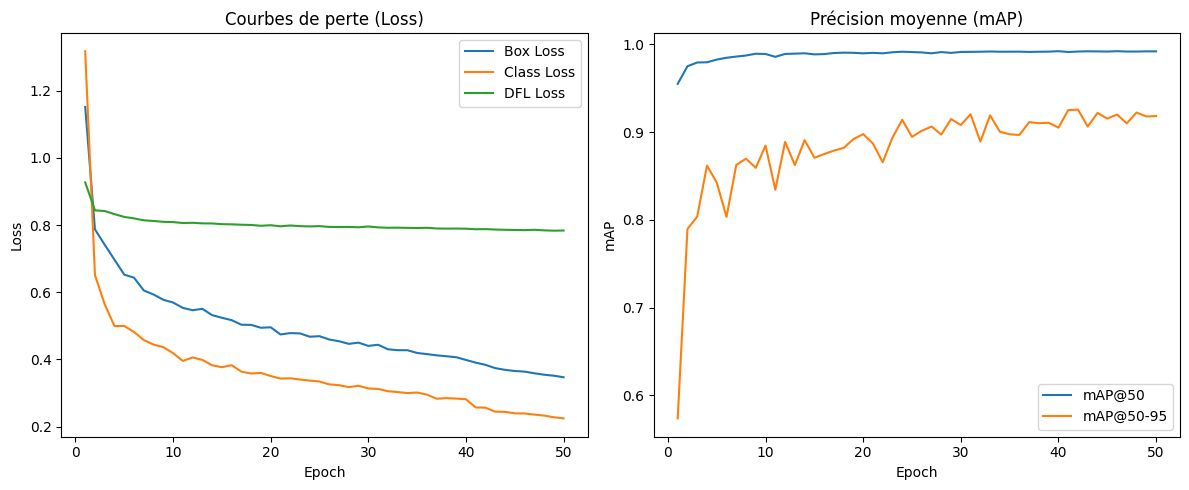

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

metrics_path = "/content/drive/MyDrive/yolo_mnist_training/mnist_yolo_run/results.csv"
df = pd.read_csv(metrics_path)

# Trouve les colonnes disponibles
cols = df.columns
print("Colonnes disponibles :", cols.tolist())

# Sélection dynamique des colonnes mAP
mAP50_col = next((c for c in cols if 'mAP50' in c and '(B)' in c), 'metrics/mAP50')
mAP5095_col = next((c for c in cols if 'mAP50-95' in c and '(B)' in c), 'metrics/mAP50-95')

plt.figure(figsize=(12,5))

# 📉 Pertes (Loss)
plt.subplot(1,2,1)
plt.plot(df['epoch'], df['train/box_loss'], label='Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Class Loss')
if 'train/dfl_loss' in df.columns:
    plt.plot(df['epoch'], df['train/dfl_loss'], label='DFL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Courbes de perte (Loss)')
plt.legend()

# 📈 Précision moyenne (mAP)
plt.subplot(1,2,2)
if mAP50_col in df.columns:
    plt.plot(df['epoch'], df[mAP50_col], label='mAP@50')
if mAP5095_col in df.columns:
    plt.plot(df['epoch'], df[mAP5095_col], label='mAP@50-95')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Précision moyenne (mAP)')
plt.legend()

plt.tight_layout()
plt.show()


DFL Loss = précision sur les bordures des boîtes.
Elle ne doit pas forcément descendre à 0.0.
Une DFL stable (0.7–0.9) + box_loss et cls_loss qui chutent → ton modèle apprend bien.
Si elle reste constante et que les performances (mAP) sont bonnes, ce n’est pas un problème.


image 1/1 /content/mnist_yolo/images/val/10.jpg: 320x320 2 0s, 2 1s, 1 4, 1 5, 1 6, 2 7s, 1 8, 15.6ms
Speed: 0.6ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /content/runs/detect/predict2


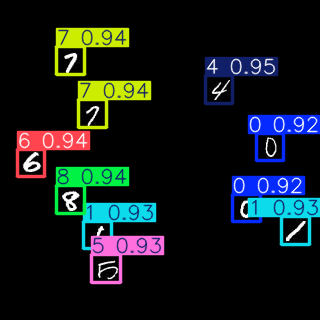

In [ ]:
# ======================================================
# 6️⃣ Test de prédiction (sur ton modèle sauvegardé sur Drive)
# ======================================================
from ultralytics import YOLO

# Chemin vers le modèle entraîné (best.pt sur ton Drive)
model_path = "/content/drive/MyDrive/yolo_mnist_training/mnist_yolo_run/weights/best.pt"

# Charger le modèle final
model = YOLO(model_path)

# Image de test
test_image = "mnist_yolo/images/val/10.jpg"

# Lancer la prédiction et sauvegarder le résultat
results = model.predict(source=test_image, save=True, imgsz=320)

# Afficher la prédiction directement dans Colab
results[0].show()



image 1/1 /content/mnist_yolo/images/val/10.jpg: 320x320 2 0s, 2 1s, 1 4, 1 5, 1 6, 2 7s, 1 8, 15.6ms
Speed: 0.8ms preprocess, 15.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 320)


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
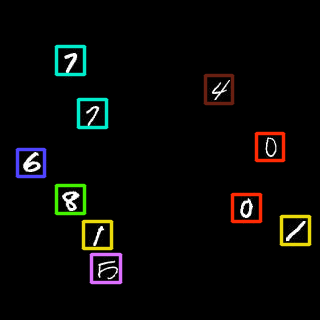

In [ ]:
from ultralytics import YOLO

# Charger ton modèle
model = YOLO("/content/drive/MyDrive/yolo_mnist_training/mnist_yolo_run/weights/best.pt")

# Faire la prédiction (sans sauvegarde automatique)
results = model.predict(source="mnist_yolo/images/val/10.jpg", save=False, imgsz=320)

# Afficher sans les probabilités
results[0].plot(conf=False, labels=False, save=True)



image 1/1 /content/mnist_yolo/images/val/10.jpg: 320x320 2 0s, 2 1s, 1 4, 1 5, 1 6, 2 7s, 1 8, 15.6ms
Speed: 0.6ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 320)


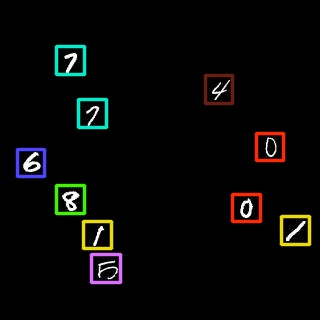

🖼️ Image sauvegardée : /content/drive/MyDrive/yolo_mnist_training/mnist_yolo_run/predictions/val10_clean.jpg
📊 Détections : 4:1, 6:1, 8:1, 7:2, 5:1, 1:2, 0:2


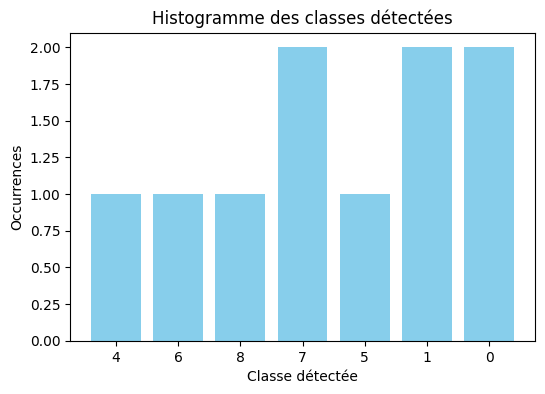

In [ ]:
# ======================================================
# Test YOLOv8 — affichage sans probas + comptage visuel des classes
# ======================================================
from ultralytics import YOLO
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display
import os

# 1️⃣ Charger le modèle
model = YOLO("/content/drive/MyDrive/yolo_mnist_training/mnist_yolo_run/weights/best.pt")

# 2️⃣ Lancer la prédiction sans sauvegarde automatique
results = model.predict(source="mnist_yolo/images/val/10.jpg", save=False, imgsz=320)

# 3️⃣ Générer et sauvegarder l’image propre (sans probas ni labels)
output_dir = "/content/drive/MyDrive/yolo_mnist_training/mnist_yolo_run/predictions"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "val10_clean.jpg")

# La fonction plot() retourne l’image → on la sauvegarde proprement
img_clean = results[0].plot(conf=False, labels=False)
import cv2
cv2.imwrite(output_path, cv2.cvtColor(img_clean, cv2.COLOR_RGB2BGR))

# 4️⃣ Afficher l’image dans Colab
display(Image(filename=output_path))
print(f"🖼️ Image sauvegardée : {output_path}")

# ======================================================
# 5️⃣ Comptage des classes détectées
# ======================================================
classes = results[0].boxes.cls.cpu().numpy().astype(int)
counts = Counter(classes)

if counts:
    # Affichage textuel
    summary = ", ".join([f"{cls}:{count}" for cls, count in counts.items()])
    print(f"📊 Détections : {summary}")

    # Tableau de comptage
    df = pd.DataFrame(list(counts.items()), columns=["Classe", "Occurrences"])
    #display(df)

    # 6️⃣ Histogramme (barres)
    plt.figure(figsize=(6,4))
    plt.bar(df["Classe"].astype(str), df["Occurrences"], color="skyblue")
    plt.xlabel("Classe détectée")
    plt.ylabel("Occurrences")
    plt.title("Histogramme des classes détectées")
    plt.show()

else:
    print("❌ Aucune détection trouvée sur cette image.")
